# Dataset

We ideally want our dataset code to be decoupled from our model training code for better readability and modularity. PyTorch provides `torch.utils.data.Dataset` that allow you to use your own data. Dataset stores the samples and their corresponding labels to enable easy access to the samples.

In [2]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from torchvision import transforms

A custom Dataset class must implement three functions: `__init__`, `__len__`, and `__getitem__`.
- The `__init__` function is run once when instantiating the Dataset object.
- The `__len__` function returns the number of samples in our dataset.
- The `__getitem__` function loads and returns a sample from the dataset at the given index idx.

In [3]:
class ToyData(Dataset):
    def __init__(self, length = 100, transform = None):
        self.len = length
        self.x = 2 * torch.ones(length, 2)
        self.y = torch.ones(length, 1)
        self.transform = transform
     
    def __getitem__(self, index):
        sample = self.x[index], self.y[index]
        if self.transform:
            sample = self.transform(sample)     
        return sample

    def __len__(self):
        return self.len

We are able to customize the indexing and length method by customizing <code>def \__getitem\_\_(self, index)</code> and <code>def \__len\_\_(self)</code>. As a result, we can apply the same indexing convention as a <code>list</code>, and apply the fuction <code>len</code> on the <code>ToyData</code> object.

In [4]:
dataset = ToyData()

for i in range(5):
    x, y = dataset[i]
    print("Index: ", i, '; x:', x, '; y:', y)

Index:  0 ; x: tensor([2., 2.]) ; y: tensor([1.])
Index:  1 ; x: tensor([2., 2.]) ; y: tensor([1.])
Index:  2 ; x: tensor([2., 2.]) ; y: tensor([1.])
Index:  3 ; x: tensor([2., 2.]) ; y: tensor([1.])
Index:  4 ; x: tensor([2., 2.]) ; y: tensor([1.])


In [5]:
len(dataset)

100

The dataset object is an Iterable; as a result, we  apply the loop directly on the dataset object.

In [6]:
for x, y in dataset:
    print(' x:', x, 'y:', y)

 x: tensor([2., 2.]) y: tensor([1.])
 x: tensor([2., 2.]) y: tensor([1.])
 x: tensor([2., 2.]) y: tensor([1.])
 x: tensor([2., 2.]) y: tensor([1.])
 x: tensor([2., 2.]) y: tensor([1.])
 x: tensor([2., 2.]) y: tensor([1.])
 x: tensor([2., 2.]) y: tensor([1.])
 x: tensor([2., 2.]) y: tensor([1.])
 x: tensor([2., 2.]) y: tensor([1.])
 x: tensor([2., 2.]) y: tensor([1.])
 x: tensor([2., 2.]) y: tensor([1.])
 x: tensor([2., 2.]) y: tensor([1.])
 x: tensor([2., 2.]) y: tensor([1.])
 x: tensor([2., 2.]) y: tensor([1.])
 x: tensor([2., 2.]) y: tensor([1.])
 x: tensor([2., 2.]) y: tensor([1.])
 x: tensor([2., 2.]) y: tensor([1.])
 x: tensor([2., 2.]) y: tensor([1.])
 x: tensor([2., 2.]) y: tensor([1.])
 x: tensor([2., 2.]) y: tensor([1.])
 x: tensor([2., 2.]) y: tensor([1.])
 x: tensor([2., 2.]) y: tensor([1.])
 x: tensor([2., 2.]) y: tensor([1.])
 x: tensor([2., 2.]) y: tensor([1.])
 x: tensor([2., 2.]) y: tensor([1.])
 x: tensor([2., 2.]) y: tensor([1.])
 x: tensor([2., 2.]) y: tensor([1.])
 

# Transforms
Data does not always come in its final processed form that is required for training machine learning algorithms. We use transforms to perform some manipulation of the data and make it suitable for training. You can also create a class for transforming the data. In this case, we will try to add 1 to our features and multiply our labels by 2.

In [6]:
class CustomTransforms(object):
    def __init__(self, addx = 1, muly = 2):
        self.addx = addx
        self.muly = muly

    def __call__(self, sample):
        x = sample[0]
        y = sample[1]
        x = x + self.addx
        y = y * self.muly
        sample = x, y
        return sample

We can apply the transform object every time we create a new <code>ToyData</code>.


In [7]:
transform = CustomTransforms()
dataset = ToyData(transform=transform)

for i in range(5):
    x, y = dataset[i]
    print("Index: ", i, '; x:', x, '; y:', y)

Index:  0 ; x: tensor([3., 3.]) ; y: tensor([2.])
Index:  1 ; x: tensor([3., 3.]) ; y: tensor([2.])
Index:  2 ; x: tensor([3., 3.]) ; y: tensor([2.])
Index:  3 ; x: tensor([3., 3.]) ; y: tensor([2.])
Index:  4 ; x: tensor([3., 3.]) ; y: tensor([2.])


# Compose
`Compose` composes several transforms together. For example, we have splitted the previous transformation into two separate classes. The `FeatureTransformer` adds `1` to all the features. On the other hand the `LabelTransformer` multiplies the labels by `2`.

In [42]:
class FeatureTransforms(object):
    def __init__(self, addx = 1):
        self.addx = addx

    def __call__(self, sample):
        x = sample[0]
        y = sample[1]
        x = x + self.addx
        sample = x, y
        return sample


class LabelTransforms(object):
    def __init__(self, muly = 2):
        self.muly = muly

    def __call__(self, sample):
        x = sample[0]
        y = sample[1]
        y = y * self.muly
        sample = x, y
        return sample

In [43]:
transform = transforms.Compose([FeatureTransforms(), LabelTransforms()])
dataset = ToyData(transform=transform)

for i in range(5):
    x, y = dataset[i]
    print("Index: ", i, '; x:', x, '; y:', y)

Index:  0 ; x: tensor([3., 3.]) ; y: tensor([2.])
Index:  1 ; x: tensor([3., 3.]) ; y: tensor([2.])
Index:  2 ; x: tensor([3., 3.]) ; y: tensor([2.])
Index:  3 ; x: tensor([3., 3.]) ; y: tensor([2.])
Index:  4 ; x: tensor([3., 3.]) ; y: tensor([2.])


# Putting Altogether

Now we will create our custom `Dataset` object to load our custom dataset.

In [8]:
directory = "datasets/mnist-fashion-small"
metadata_name ='metadata.csv'
img_dir = 'img'

In [9]:
metadata_path = os.path.join(directory, metadata_name)
metadata = pd.read_csv(metadata_path)

In [10]:
metadata.head()

,category,image
0,Ankle boot,img/fashion0.png
1,T-shirt,img/fashion1.png
2,T-shirt,img/fashion2.png
3,Dress,img/fashion3.png
4,T-shirt,img/fashion4.png


In [11]:
image_name = metadata.iloc[1, 1]
image_name

'img/fashion1.png'

In [12]:
image_path = os.path.join(directory, image_name)
image_path

'datasets/mnist-fashion-small/img/fashion1.png'

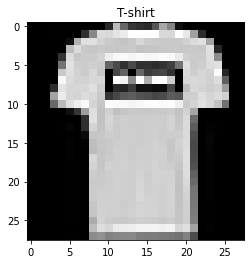

In [13]:
image = Image.open(image_path)
plt.imshow(image, cmap='gray', vmin=0, vmax=255)
plt.title(metadata.iloc[1, 0])
plt.show()

In [36]:
class Dataset(Dataset):
    def __init__(self, metadata_name, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.metadata = pd.read_csv(os.path.join(data_dir, metadata_name))
        self.len = self.metadata.shape[0] 

    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.data_dir, self.metadata.iloc[idx, 1])
        image = Image.open(img_name)    
        y = metadata.iloc[idx, 0]

        if self.transform:
            image = self.transform(image)

        return image, y

In [37]:
dataset = Dataset(metadata_name=metadata_name, data_dir=directory)

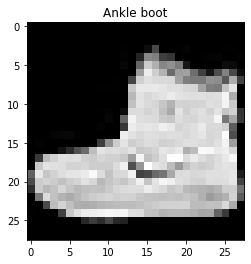

In [38]:
plt.imshow(dataset[0][0], cmap='gray')
plt.title(dataset[0][1])
plt.show()

The torchvision.transforms module offers several commonly-used transforms out of the box. For example, The features are in PIL Image format. For training, we need the features as normalized tensors. To make these transformations, we use the built-in `ToTensor` transformation.

In [39]:
croptensor_data_transform = transforms.Compose([transforms.CenterCrop(20), transforms.ToTensor()])
dataset = Dataset(metadata_name=metadata_name, data_dir=directory,
                  transform=croptensor_data_transform )

In [40]:
dataset[0][0].shape

torch.Size([1, 20, 20])

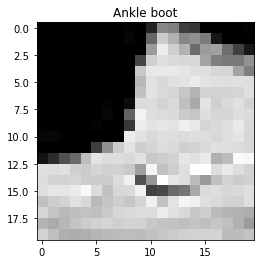

In [41]:
plt.imshow(dataset[0][0].squeeze(0), cmap='gray')
plt.title(dataset[0][1])
plt.show()